In [265]:
import numpy as np

import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier 

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)



In [289]:
path = "./Absenteeism_at_work.csv"
df = pd.read_csv(path, sep=";")
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,...,0,1,2,1,0,1,90,172,30,8
736,1,11,7,3,1,235,11,14,37,264.604,...,0,3,1,0,0,1,88,172,29,4
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0


# Formation des datasets

Il y a trois configurations possibles des datasets par la fonction `initDataSet(df, i, grp)`, où i est le numéro du dataset à sélectionner.
-  Dataset numéro 1 :  

        - Suppression des lignes de mois d'absence à 0,
        - Changement des données en temps d'absence à 0 et raison 27 par la médiane des temps d'absences des raisons 27,
        - Changement des données en temps d'absence à 0 et échec disciplinaire à 0 par l'échec disciplinaire à 1
        - Changement des données en temps d'absence à 0 par la médiane des temps d'absences
        
- Dataset numéro 2 :

        - Suppression des lignes de mois d'absence à 0,
        - Suppression des lignes où le temps d'absence est à 0

- Dataset numéro 3 :

        - Aucune modifcation
        
Toutes les données privée sauf la colonne "temps d'absence" (la dernière) seront des données non cible. Une partie subisse une tranformation selon leur type de données. Les données catégorielles sont construites selon l'encodage à chaud, les données numériques sont normalisées et seulement les colonnes booléennes ne sont pas tranformées.

Les données cibles quant-à-elles, sont tranformer en n valeurs choisit, regroupant, les classes. Ainsi, par exmple [[0, 1, 2], [3]], la première classe sera tous les temps égaux à 0, 1 ou 2 heures, tandis que la seconde sera les temps surpérieurs à 3. Tous nombre non selectionné va automatiquement dans la dernière colonnes. On peut ainsi identifier les pourentages de réprésentation des classes au travers de la dataset transformés.
 
Enfin, les données sont séparer de la manière suivante 20 % en test et 80 % en entrainnement. 

In [461]:
features = df.columns
def typeData (df, i = 2):
    """
    La formation des dataset suivent la constation dans le notebook "Analyse".
    -  Dataset numéro 1 : 
            - Suppression des lignes de mois d'absence à 0,
            - Changement des données en temps d'absence à 0 et raison 27 par la médiane des temps d'absences des raisons 27,
            - Changement des données en temps d'absence à 0 et échec disciplinaire à 0 par l'échec disciplinaire à 1
            - Changement des données en temps d'absence à 0 par la médiane des temps d'absences
    - Dataset numéro 2 :
            - Suppression des lignes de mois d'absence à 0,
            - Suppression des lignes où le temps d'absence est à 0
    - Dataset numéro 3 :
            - Aucune modifcation
    """
    dfTemp = df.copy()
    features = df.columns
    s = ""
    if (i == 1):
        dfTemp = dfTemp[dfTemp['Month of absence'] != 0]
        mediane = np.percentile(dfTemp[dfTemp['Reason for absence']==27][['Absenteeism time in hours']], 50)
        dfTemp.loc[(dfTemp['Reason for absence']==27) & (dfTemp['Absenteeism time in hours']==0),'Absenteeism time in hours'] =  round(mediane)
        dfTemp.loc[((dfTemp['Absenteeism time in hours']==0) & (dfTemp['Disciplinary failure']!=1)),'Disciplinary failure'] = 1 
        s = " - Suppression les lignes du mois d'absence à 0,\n - Changement les données en temps 0 et raison 27 par la médiane des temps d'abences des raisons 27, \n - Changement les données en temps 0 et echec disciplinaire à 0 par la echec disciplinaire à 1,"
        mediane = np.percentile(dfTemp[dfTemp['Absenteeism time in hours']==0], 50)
        dfTemp.loc[(dfTemp['Absenteeism time in hours']==0),'Absenteeism time in hours'] = round(mediane)
        s += "\n - Changement les données en temps d'absence à 0 par la médiane des temps d'absences"

    elif(i == 2):
        dfTemp = dfTemp[dfTemp['Month of absence'] != 0]
        dfTemp = dfTemp[(dfTemp[features[1]]!=0) & (dfTemp[features[-1]]!=0)]
        s = " - Suppression les lignes de mois de l'absence à 0,\n - Suppression des lignes où le temps d'absence est à 0"

    print(s)
    return dfTemp 


In [288]:
def initDataSet(df, i, grp = [[0, 1, 2, 3 ], [4]]):
    ###### Données utilisée :
    print("Forme du dataset :\n")
    Dataset = typeData(df, i)

    ###### Référencemence des colonnes :
    features = list(Dataset.columns)

    ########## Partie Gestion de y ##########
    # Mise en forme d'intervale 

    y = Dataset.loc[:, features[-1]]
    sumC = [0 for g in grp]
    u = (y.unique()).tolist()
    l = [[i, y[y==i].count()] for i in u]
    l.sort()
    s = 0
    for e in l:
        for i, choix in enumerate(grp): 
            if e[0] in choix:
                sumC[i] += e[1]
                y = y.replace(e[0], i)
            elif (len(grp)-1) == i and e[0] >= choix[0]:
                sumC[i] += e[1]
                y = y.replace(e[0], i)
        s += e[1]
    lt = len(y)
    print("\n" ,grp, "\n Pourcentage par groupe :\n", [c/lt*100 for c in sumC])

    ########## Partie Gestion de X ##########
    # Mise à la même échelle des données numériques (z = (x - u) / s)
    # Encodage à chaud pour les données catégorielles (Sous forme d'un tableau de booléen).
    # Cela permet notamment de mettre à la même échelle l'ensemble des données
    
    TableauCat = Dataset[features[0:5] + features[12:13]]
    TableauNoChange = Dataset[features[11:12] + features[14:16]]
    TableauNum = Dataset[features[5:11] + features[13:14] + features[16:20]]
    
    ### Normalisation des données numériques
    TableauNum = StandardScaler().fit_transform(TableauNum)

    ### Encodage à chaud des colonnes catégories
    features = list(TableauCat.columns)
    for name in features: 
        categorieCol = pd.get_dummies(TableauCat[name])
        FeatoFCat = categorieCol.columns
        for idx, col in enumerate(FeatoFCat):
            TableauNum = np.c_[TableauNum,categorieCol[col].to_numpy()]

    X = np.concatenate((TableauNum, TableauNoChange.to_numpy()), axis=1)

    return train_test_split(X, y, test_size = 0.20)

In [421]:
grp = [[0, 1, 2], [3, 4, 5, 6, 7], [8]]
X_train, X_test, y_train, y_test = initDataSet(df, 2, grp)

Forme du dataset :

 - Suppression les lignes de mois de l'absence à 0,
 - Suppression des lignes où le temps d'absence est à 0

 [[0, 1, 2], [3, 4, 5, 6, 7], [8]] 
 Pourcentage par groupe :
 [35.201149425287355, 25.862068965517242, 38.93678160919541]


# Fonction de sélection des hyperparamètres

In [448]:

"""
Fonction qui cherche à trouver la meilleure moyenne de prédiction 
pour toutes les possibilités d’un paramètre, ensuite réitère le processus.
Cela permet dans une première phase de trouver une combinaison générale 
puis de modifier sur cette base. 

"""

Parametre = {
    "solver": [ "sgd", "adam"],
    "activation":  ["identity", "logistic", "tanh", "relu"],
    "alpha":  [10**(-5), 0.001, 0.1, 10],
    "learning_rate_init":  [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    "learning_rate": ["constant", "adaptive"],
    "max_iter":  [1000, 500, 200],
    'random_state':[0,1,2,3,4,5,6,7,8,9],
    "hidden_layer_sizes": {
          "one":list(range(2, 22, 2)),
          "two":list(range(2, 22, 2)),
          "three":list(range(2, 22, 2))
      }
}


def get_score(mlp, X_train, X_test, y_train, y_test):
    mlp.fit(X_train, y_train.values.ravel())
    predictions = mlp.predict(X_test)
    return accuracy_score(y_test,predictions)

def placeParam(model, key, params):
    if(key=="solver"): model.solver = params
    elif(key=="activation"): model.activation = params
    elif(key=="alpha"): model.alpha = params
    elif(key=="learning_rate_init"): model.learning_rate_init = params
    elif(key=="learning_rate"): model.learning_rate = params
    elif(key=="max_iter"): model.max_iter = params
    elif(key=="hidden_layer_sizes"): model.hidden_layer_sizes = params
    elif(key=="random_state"): model.random_state = params
    return model

numberTest = 10

mlp = MLPClassifier() 
storageConfig = []
for key in Parametre:
    avrKey = []
    keepNeural = ()
    for val in Parametre[key]:
        if (key != "hidden_layer_sizes"):

            mlp = placeParam(mlp, key, val)
            calculMoy = []
            for i in range(numberTest):
                calculMoy.append(get_score(mlp, X_train, X_test, y_train, y_test))
            avrKey.append([ (np.array(calculMoy)).mean(), val])
    
        else: 
            avrNeural = []
            for neural in Parametre[key][val]:
                baseN = keepNeural + (neural,)
                mlp = placeParam(mlp, key, baseN)
                calculMoy = []
                for i in range(numberTest):
                    calculMoy.append(get_score(mlp, X_train, X_test, y_train, y_test))
                avrNeural.append([(np.array(calculMoy)).mean(), baseN])
                avrNeural.sort(reverse=True)
            keepNeural = avrNeural[0][1]
            avrKey.append([avrNeural[0][0], avrNeural[0][1]])

    avrKey.sort(reverse=True)
    storageConfig.append(avrKey[0])
    mlp = placeParam(mlp, key, avrKey[0][1])
    print("finit : "+ key)
    print("\n")

print("Configuration trouvée \n")
print(storageConfig)

finit : solver


finit : activation


finit : alpha


finit : learning_rate_init


finit : learning_rate


finit : max_iter


finit : random_state


finit : hidden_layer_sizes


Configuration trouver
[[0.6642857142857144, 'adam'], [0.687857142857143, 'identity'], [0.6900000000000001, 1e-05], [0.6921428571428572, 0.0005], [0.6921428571428572, 'adaptive'], [0.6950000000000001, 200], [0.6928571428571428, 8], [0.6928571428571428, (18, 10, 2)]]


## Modèle pour classification à trois classe :  

Pour df numéro 1 : réussite à 70 %  
['adam', 'logistic', 0.001, 0.001, 'constant', 200, 1, (16, 18, 10)]

Pour df numéro 2 : réussite à 73 %  
['adam', 'logistic', 1e-05, 0.001, 'adaptive', 500, 9, (20, 20, 20)]

Pour df numéro 3 : réussite à 72 %  
['adam', 'logistic', 0.001, 0.001, 'adaptive', 200, 5, (18, 4)]

*Ordre des paramètres du NN dans la liste: Solver, activation, alpha, learning_rate_init, learning_rate, iter, random_state, layer

## Solution retenue :

Le DF 2 semble obtenir les meilleurs prédictions 

# Partie visualisation de l'apprentissage et paramétrage manuel

In [452]:
comparaisonList = []
metriqueComp = []
print("Configuration conseiller avant paramétrage manuel :\n")
print("Solver, activation, alpha, learning_rate_init, lr, iter,  layer")
[comp[1] for comp in storageConfig]

Configuration conseiller avant paramétrage manuel :

Solver, activation, alpha, learning_rate_init, lr, iter,  layer


['adam', 'identity', 1e-05, 0.0005, 'adaptive', 200, 8, (18, 10, 2)]

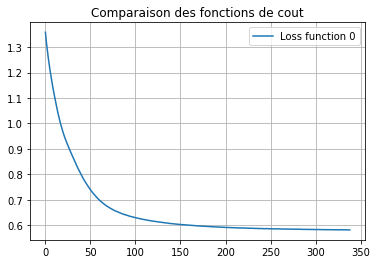

La matrice de confusion :
[[47 11  4]
 [11 12  5]
 [ 5  7 38]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.75        62
           1       0.40      0.43      0.41        28
           2       0.81      0.76      0.78        50

    accuracy                           0.69       140
   macro avg       0.65      0.65      0.65       140
weighted avg       0.70      0.69      0.70       140

[0.6928571428571428, 'learning_rate_init : 0.001', 'alpha : 0.001', 'max_iter : 500', 'activation : identity', 'learning_rate : adaptive', 'solver : adam', 'hidden_layer : (18, 2, 6)']


In [446]:
###### Mise en oeuvre du RN ######
mlp = MLPClassifier() 


###### Paramètre ######
mlp.solver = "adam"
mlp.activation = "identity"
mlp.alpha = 10**(-5)
mlp.learning_rate_init = 0.001
mlp.learning_rate = "adaptive" 
mlp.max_iter = 500 
mlp.random_state = 8
mlp.hidden_layer_sizes=(18, 10, 6)

###### Apprentissage du modèle ######
mlp.fit(X_train, y_train.values.ravel())
predictions = mlp.predict(X_test)

###### Figure de comparaison des courbes d'apprentissages ######
plt.figure()
if len(comparaisonList) > 3 : comparaisonList.remove(comparaisonList[0]) 
comparaisonList.append(mlp.loss_curve_)
for idx, loss in enumerate(comparaisonList): plt.plot(loss, label=('Loss function '+str(idx)))
plt.title("Comparaison des fonctions de coût")
plt.legend()
plt.grid()
plt.show()

###### Matrice de confusion #######
print("La matrice de confusion :")
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))


###### Enregistrement automatique des meilleurs 
#       résultats par tatonnement #######
metriqueComp.append([
  accuracy_score(y_test,predictions),
  "learning_rate_init : "+str(mlp.learning_rate_init),
  "alpha : "+str(mlp.alpha),
  "max_iter : "+str(mlp.max_iter),
  "activation : "+str(mlp.activation),
  "learning_rate : "+str(mlp.learning_rate),
  "solver : "+str(mlp.solver),
  "hidden_layer : "+str(mlp.hidden_layer_sizes)
])
metriqueComp.sort(reverse=True)
if len(metriqueComp) > 3 : metriqueComp.remove(metriqueComp[-1]) 
for d in metriqueComp[0:3]: print(d) 